In [1]:
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]=""

import numpy as np
import itertools
from glob import glob

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

In [2]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

#### Import model, training function 

In [3]:
from annsa.model_classes import (DNN,
                                 CNN1D)

from annsa.load_pretrained_network import load_trained_model

from annsa.results_plotting_functions import *

# Load all models into dictionaries

In [4]:
all_models = {}
all_models_dataaug = {}

### Load networks trained with data augmentation

In [5]:
all_models_dataaug = {}

for path in glob('../final_training_notebooks/final-models/learningcurve-*-dataaug-final_checkpoint*[0-9].i*'):

    model_id = path.split('learningcurve-')[1].split('_checkpoint')[0]
    model_index = path.split('checkpoint-')[1][0]
    model_id_complete = model_id+'-'+model_index
    print(model_id_complete)
    
    if 'c' in model_id:
        model_class = CNN1D
    else:
        model_class = DNN
    features_file_path = '../final_training_notebooks/final-models/learningcurve-'+model_id+'-features'
    weights_file_path = '../final_training_notebooks/final-models/learningcurve-'+model_id+'_checkpoint-'+model_index
    
    trained_model, _ = load_trained_model(model_class,
                                          features_file_path,
                                          weights_file_path,
                                          )

    all_models_dataaug[model_id_complete] = trained_model

cnn-easy-dataaug-final-4
dae-full-dataaug-final-4
dnn-easy-dataaug-final-3
cnn-full-dataaug-final-1
cae-easy-dataaug-final-2
dnn-full-dataaug-final-0
cae-easy-dataaug-final-1
cae-full-dataaug-final-2
cae-easy-dataaug-final-0
cae-easy-dataaug-final-3
dae-easy-dataaug-final-4
cae-full-dataaug-final-0
dnn-easy-dataaug-final-1
cnn-easy-dataaug-final-0
cnn-easy-dataaug-final-2
dae-easy-dataaug-final-0
dae-easy-dataaug-final-2
dae-full-dataaug-final-3
dnn-easy-dataaug-final-0
dae-full-dataaug-final-2
cae-full-dataaug-final-3
cae-full-dataaug-final-1
dnn-full-dataaug-final-1
cae-easy-dataaug-final-4
cnn-easy-dataaug-final-3
dnn-easy-dataaug-final-2
cae-full-dataaug-final-4
dae-easy-dataaug-final-1
dae-easy-dataaug-final-3
dae-full-dataaug-final-1
cnn-full-dataaug-final-0
dae-full-dataaug-final-0
cnn-easy-dataaug-final-1
dnn-easy-dataaug-final-4


### Load networks trained with fixed-size datasets

In [6]:
trainsize = 10000
file_path = '../final_training_notebooks/final-models/learningcurve-'

for path in glob(file_path+'*final*'+'_trainsize_'+str(trainsize)+'_*.index'):
    if 'stop' in path:
        continue
    model_id = path.split('learningcurve-')[1].split('_trainsize')[0]
    model_index = path.split('checkpoint_')[1][0]
    model_id_complete = model_id+'-'+model_index
    print(model_id_complete)
    
    if 'c' in model_id:
        model_class = CNN1D
    else:
        model_class = DNN
    features_file_path = '../final_training_notebooks/final-models/learningcurve-'+model_id+'-features'
    weights_file_path = '../final_training_notebooks/final-models/learningcurve-'+model_id+'_trainsize_'+str(trainsize)+'_checkpoint_'+model_index
    
    trained_model, _ = load_trained_model(model_class,
                                          features_file_path,
                                          weights_file_path,
                                          )
    all_models[model_id_complete] = trained_model
    
all_models.pop('cae-easy-final-5')
all_models.pop('cae-easy-final-6')

dae-easy-final-1
dnn-full-final-1
dae-easy-final-0
cae-easy-final-1
cae-easy-final-4
dae-easy-final-2
dnn-easy-final-4
dnn-easy-final-0
cnn-easy-final-0
cae-easy-final-0
cae-full-final-0
cae-full-final-2
cnn-easy-final-2
cae-full-final-3
dae-easy-final-4
cae-full-final-1
cae-easy-final-2
dae-full-final-4
cnn-full-final-2
cnn-easy-final-3
dae-full-final-0
cae-full-final-4
dnn-easy-final-2
cae-easy-final-3
cae-easy-final-5
cnn-full-final-0
dnn-full-final-4
dnn-easy-final-3
dnn-full-final-0
dnn-full-final-2
cnn-easy-final-1
dnn-easy-final-1
cae-easy-final-6
dae-full-final-2
cnn-easy-final-4
dnn-full-final-3
cnn-full-final-1
dae-full-final-1
dae-full-final-3
dae-easy-final-3


## Plot F1 score vs integration time with different source-detector distances

In [7]:
sourceheights = [50.0, 75.0, 100.0, 125.0, 150.0]
fwhms = [6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0]
sourcedists = [50.0, 112.5, 175.0, 237.5, 300.0]

In [8]:
spectra_dataframe_lead = pd.read_pickle('spectra_dataframe_shielding_lead')
spectra_dataframe_iron = pd.read_pickle('spectra_dataframe_shielding_iron')
spectra_dataframe_alum = pd.read_pickle('spectra_dataframe_shielding_alum')

In [9]:
def plot_f1_scores_bagged(dataframe,
                          model_ids,
                          all_models,
                          indep_variable,
                          plot_label,
                          linestyle,
                          color,
                          **kwargs,
                          ):
    '''
    Plots the F1 scores for model's in model_ids given some dataframe of spectra.

    Inputs
        dataframe : Pandas DataFrame
            DataFrame containing spectra, isotope names, and
            parameter options.
        model_ids : string, list
            List of model_id strings to bag. Specific model_id examples are
            'dnn-full' or 'cae-easy'.
        all_models : dict
            Dictionary containing all models
        indep_variable : str
            The key for accessing the data column that contains the independent
            variable data. This data is plotted on the x-axis.
        kwargs : list, int, float
            Choices of different parameters to simulate

    Outputs
        None
    '''
    mlb = LabelBinarizer()
    keys = list(set(dataframe['isotope']))
    mlb.fit(keys)

    plt.rcParams.update({'font.size': 20})
    f1_scores_models = {}
    for key, value in kwargs.items():
        dataframe = dataframe[dataframe[key] == value]
    for model_id in model_ids:
        tmp_f1_scores = []
        for var in sorted(set(dataframe[indep_variable])):

            subset = dataframe[indep_variable] == var
            tmp_f1_score = f1_score_bagged([model_id],
                                all_models,
                                np.vstack(dataframe[subset]['spectrum'].to_numpy()),
                                mlb.transform(dataframe['isotope'])[subset],)
            tmp_f1_scores.append(tmp_f1_score[model_id])

        # f1_scores_models[model_id] = tmp_f1_scores
        if plot_label:
            plt.plot(tmp_f1_scores,
                     label=plot_label,
                     linestyle=linestyle,
                     linewidth=2.5,
                     color=color,)
        else:
            plt.plot(tmp_f1_scores,
                     label=model_id,
                     linestyle=linestyle,
                     linewidth=2.5,
                     color=color,)
#     plt.legend()
    plt.xlabel(indep_variable)
    plt.ylabel('F1 Score')
    plt.ylim([0, 1])
    plt.xticks(
        range(len(sorted(set(dataframe[indep_variable])))),
        [round(var, 2) for var in sorted(set(dataframe[indep_variable]))])

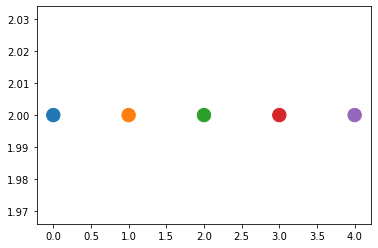

In [10]:
import matplotlib.colors

def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

c1 = categorical_cmap(5,1, cmap="tab10")
plt.scatter(np.arange(5*1),np.ones(5*1)+1, c=np.arange(5*1), s=180, cmap=c1)


In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          text_size=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] == 0:
            continue
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 size=text_size)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [12]:
def confusion_matricies_bagged(model_ids,
                               all_models,
                               dataframe,
                               **kwargs,):
#                                testing_spectra,
#                                testing_keys_binarized,):

    

        
    for key, value in kwargs.items():
        dataframe = dataframe[dataframe[key] == value]
    
    mlb = LabelBinarizer()
    keys = list(set(dataframe['isotope']))
    mlb.fit(keys)

    for model_id in model_ids:

        predictions, _ = models_bagged(all_models, model_id, np.vstack(dataframe['spectrum'].to_numpy()))
        true_labels = mlb.transform(dataframe['isotope']).argmax(axis=1)

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(true_labels, predictions)
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure(figsize=(10,10))
        _ = plot_confusion_matrix(cnf_matrix, classes=mlb.classes_, normalize=True,
                                  title='Normalized confusion matrix',
                                  text_size = 0,)
        plt.title(model_id)

In [13]:
model_ids_easy = ['cae-easy-final', 'dae-easy-final', 'dnn-easy-final', 'cnn-easy-final']
model_ids_full = ['cae-full-final', 'dae-full-final', 'dnn-full-final', 'cnn-full-final']
linestyles = ['-', '--', '-.']

# Fixed training dataset 

In [14]:
spectra_dataframe = spectra_dataframe_lead

In [15]:
save_fig = False

In [16]:
dataframe_data = []

### Model trained on easy dataset

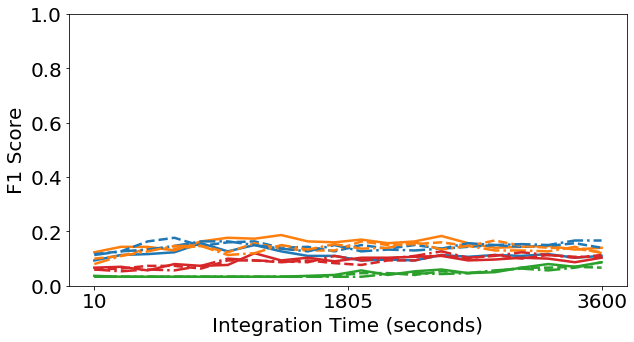

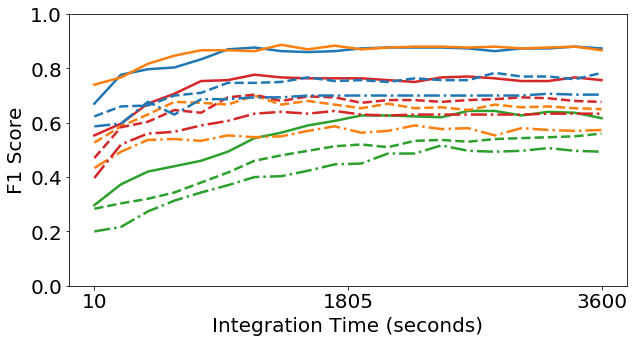

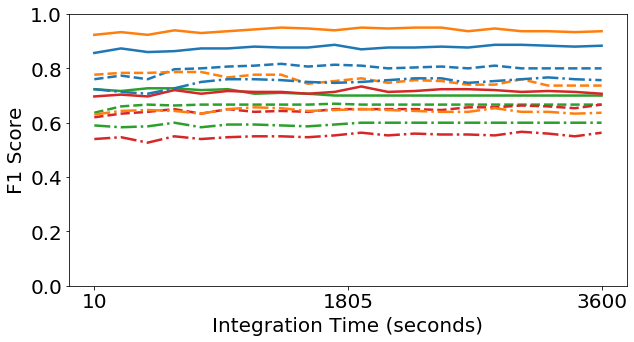

In [17]:
for signal_to_background in [0.1, 0.5, 2.0]:
    model_ids = model_ids_easy

    plt.figure(figsize=(10,5))
    # options = set(spectra_dataframe['sourcedist'])
    options = sorted(list(set(spectra_dataframe['shieldingdensity'])))[1:4]


    for option_index, option in enumerate(options):
        for model_idindex, model_id in enumerate(model_ids):
            plot_f1_scores_bagged(spectra_dataframe,
                               model_ids=[model_id],
                               all_models=all_models,
                               plot_label= str(option)+' '+str(model_id),
                               indep_variable='integration_time',
                               signal_to_background=signal_to_background,
                               sourceheight=100.0,
                               sourcedist=175.0,
                               fwhm=7.0,
                               shieldingdensity=option,
                               linestyle=linestyles[option_index],
                               color=c1.colors[model_idindex],
                               )

    plt.xlabel('Integration Time (seconds)')
    plt.xticks(np.linspace(0,len(set(spectra_dataframe['integration_time']))-1,3), np.linspace(10,3600,3).astype(int))
    if save_fig:
        plt.savefig('realspectra-cal-'+isotope+'-'+str(signal_to_background)[2]+'-'+setting)

### Model trained on full dataset

([<matplotlib.axis.XTick at 0x7f597381e4e0>,
 <a list of 3 Text xticklabel objects>)

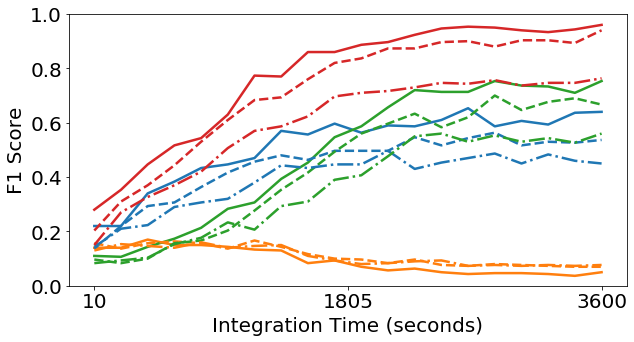

In [18]:
model_ids = model_ids_full

plt.figure(figsize=(10,5))
# options = set(spectra_dataframe['sourcedist'])
options = sorted(list(set(spectra_dataframe['shieldingdensity'])))[1:4]


for option_index, option in enumerate(options):
    for model_idindex, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe,
                           model_ids=[model_id],
                           all_models=all_models,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.1,
                           sourceheight=100.0,
                           sourcedist=175.0,
                           fwhm=7.0,
                           shieldingdensity=option,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_idindex],
                           )

plt.xlabel('Integration Time (seconds)')
plt.xticks(np.linspace(0,len(set(spectra_dataframe['integration_time']))-1,3), np.linspace(10,3600,3).astype(int))

([<matplotlib.axis.XTick at 0x7f59c07186a0>,
 <a list of 3 Text xticklabel objects>)

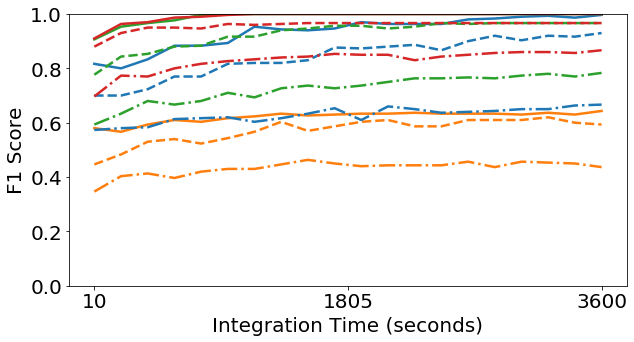

In [19]:
model_ids = model_ids_full

plt.figure(figsize=(10,5))
# options = set(spectra_dataframe['sourcedist'])
options = sorted(list(set(spectra_dataframe['shieldingdensity'])))[1:4]


for option_index, option in enumerate(options):
    for model_idindex, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe,
                           model_ids=[model_id],
                           all_models=all_models,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.5,
                           sourceheight=100.0,
                           sourcedist=175.0,
                           fwhm=7.0,
                           shieldingdensity=option,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_idindex],
                           )

plt.xlabel('Integration Time (seconds)')
plt.xticks(np.linspace(0,len(set(spectra_dataframe['integration_time']))-1,3), np.linspace(10,3600,3).astype(int))

([<matplotlib.axis.XTick at 0x7f5982a24390>,
 <a list of 3 Text xticklabel objects>)

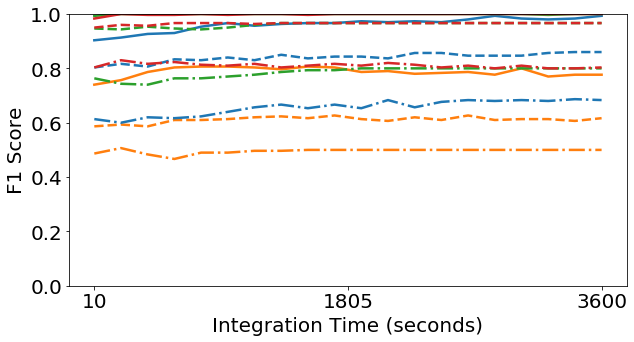

In [20]:
model_ids = model_ids_full

plt.figure(figsize=(10,5))
# options = set(spectra_dataframe['sourcedist'])
options = sorted(list(set(spectra_dataframe['shieldingdensity'])))[1:4]


for option_index, option in enumerate(options):
    for model_idindex, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe,
                           model_ids=[model_id],
                           all_models=all_models,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=2.0,
                           sourceheight=100.0,
                           sourcedist=175.0,
                           fwhm=7.0,
                           shieldingdensity=option,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_idindex],
                           )

plt.xlabel('Integration Time (seconds)')
plt.xticks(np.linspace(0,len(set(spectra_dataframe['integration_time']))-1,3), np.linspace(10,3600,3).astype(int))

# Data augmented training dataset

In [127]:
model_ids_easy = ['cae-easy-dataaug-final', 'dae-easy-dataaug-final', 'dnn-easy-dataaug-final', 'cnn-easy-dataaug-final']
model_ids_full = ['cae-full-dataaug-final', 'dae-full-dataaug-final', 'dnn-full-dataaug-final', 'cnn-full-dataaug-final']

### Model trained on easy dataset

([<matplotlib.axis.XTick at 0x7f548e8cf780>,
 <a list of 3 Text xticklabel objects>)

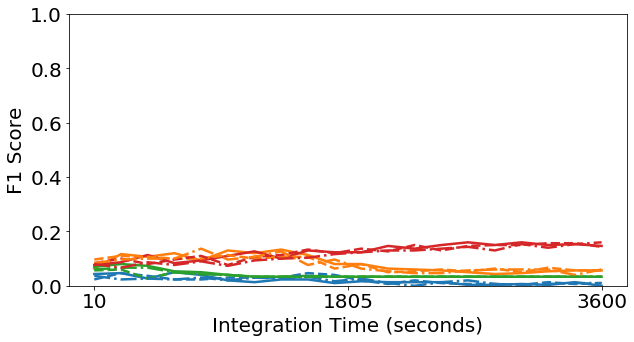

In [128]:
model_ids = model_ids_easy

plt.figure(figsize=(10,5))
# options = set(spectra_dataframe['sourcedist'])
options = sorted(list(set(spectra_dataframe['shieldingdensity'])))[1:4]


for option_index, option in enumerate(options):
    for model_idindex, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe,
                           model_ids=[model_id],
                           all_models=all_models_dataaug,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.1,
                           sourceheight=100.0,
                           sourcedist=175.0,
                           fwhm=7.0,
                           shieldingdensity=option,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_idindex],
                           )

plt.xlabel('Integration Time (seconds)')
plt.xticks(np.linspace(0,len(set(spectra_dataframe['integration_time']))-1,3), np.linspace(10,3600,3).astype(int))

([<matplotlib.axis.XTick at 0x7f548c954fd0>,
 <a list of 3 Text xticklabel objects>)

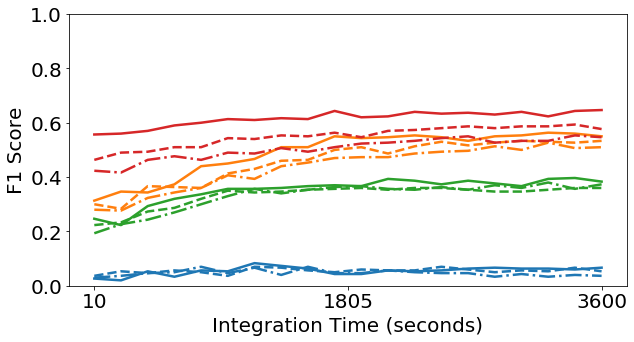

In [129]:
model_ids = model_ids_easy

plt.figure(figsize=(10,5))
# options = set(spectra_dataframe['sourcedist'])
options = sorted(list(set(spectra_dataframe['shieldingdensity'])))[1:4]


for option_index, option in enumerate(options):
    for model_idindex, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe,
                           model_ids=[model_id],
                           all_models=all_models_dataaug,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.5,
                           sourceheight=100.0,
                           sourcedist=175.0,
                           fwhm=7.0,
                           shieldingdensity=option,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_idindex],
                           )

plt.xlabel('Integration Time (seconds)')
plt.xticks(np.linspace(0,len(set(spectra_dataframe['integration_time']))-1,3), np.linspace(10,3600,3).astype(int))

([<matplotlib.axis.XTick at 0x7f53bdbb0828>,
 <a list of 3 Text xticklabel objects>)

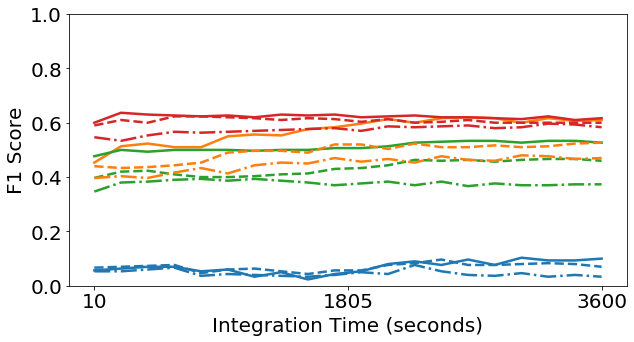

In [130]:
model_ids = model_ids_easy

plt.figure(figsize=(10,5))
# options = set(spectra_dataframe['sourcedist'])
options = sorted(list(set(spectra_dataframe['shieldingdensity'])))[1:4]


for option_index, option in enumerate(options):
    for model_idindex, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe,
                           model_ids=[model_id],
                           all_models=all_models_dataaug,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=2.0,
                           sourceheight=100.0,
                           sourcedist=175.0,
                           fwhm=7.0,
                           shieldingdensity=option,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_idindex],
                           )

plt.xlabel('Integration Time (seconds)')
plt.xticks(np.linspace(0,len(set(spectra_dataframe['integration_time']))-1,3), np.linspace(10,3600,3).astype(int))

### Model trained on full dataset

([<matplotlib.axis.XTick at 0x7f547dfb9080>,
 <a list of 3 Text xticklabel objects>)

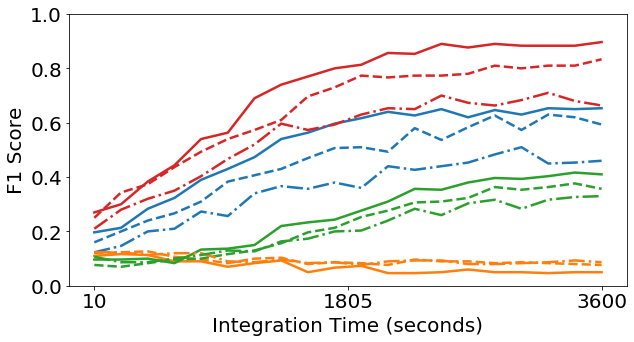

In [131]:
model_ids = model_ids_full

plt.figure(figsize=(10,5))
# options = set(spectra_dataframe['sourcedist'])
options = sorted(list(set(spectra_dataframe['shieldingdensity'])))[1:4]


for option_index, option in enumerate(options):
    for model_idindex, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe,
                           model_ids=[model_id],
                           all_models=all_models_dataaug,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.1,
                           sourceheight=100.0,
                           sourcedist=175.0,
                           fwhm=7.0,
                           shieldingdensity=option,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_idindex],
                           )

plt.xlabel('Integration Time (seconds)')
plt.xticks(np.linspace(0,len(set(spectra_dataframe['integration_time']))-1,3), np.linspace(10,3600,3).astype(int))

([<matplotlib.axis.XTick at 0x7f547f757898>,
 <a list of 3 Text xticklabel objects>)

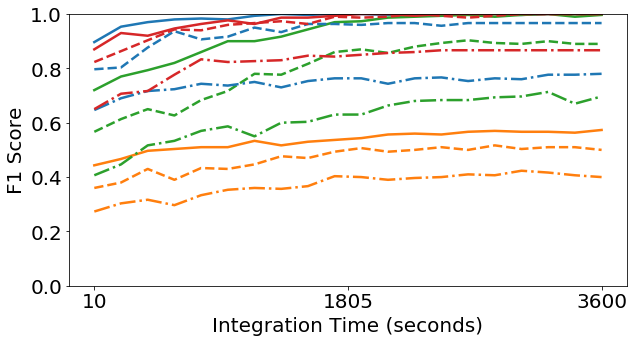

In [132]:
model_ids = model_ids_full

plt.figure(figsize=(10,5))
# options = set(spectra_dataframe['sourcedist'])
options = sorted(list(set(spectra_dataframe['shieldingdensity'])))[1:4]


for option_index, option in enumerate(options):
    for model_idindex, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe,
                           model_ids=[model_id],
                           all_models=all_models_dataaug,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.5,
                           sourceheight=100.0,
                           sourcedist=175.0,
                           fwhm=7.0,
                           shieldingdensity=option,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_idindex],
                           )

plt.xlabel('Integration Time (seconds)')
plt.xticks(np.linspace(0,len(set(spectra_dataframe['integration_time']))-1,3), np.linspace(10,3600,3).astype(int))

([<matplotlib.axis.XTick at 0x7f54cc6b30f0>,
 <a list of 3 Text xticklabel objects>)

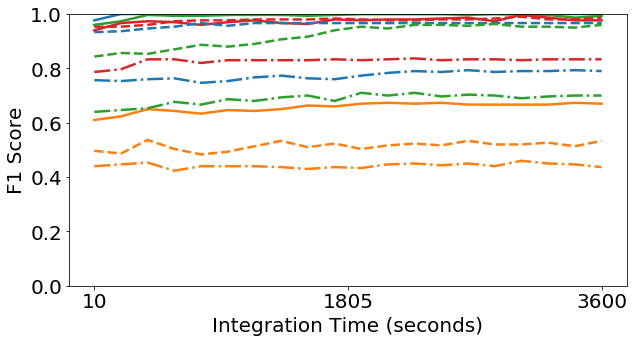

In [133]:
model_ids = model_ids_full

plt.figure(figsize=(10,5))
# options = set(spectra_dataframe['sourcedist'])
options = sorted(list(set(spectra_dataframe['shieldingdensity'])))[1:4]


for option_index, option in enumerate(options):
    for model_idindex, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe,
                           model_ids=[model_id],
                           all_models=all_models_dataaug,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=2.0,
                           sourceheight=100.0,
                           sourcedist=175.0,
                           fwhm=7.0,
                           shieldingdensity=option,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_idindex],
                           )

plt.xlabel('Integration Time (seconds)')
plt.xticks(np.linspace(0,len(set(spectra_dataframe['integration_time']))-1,3), np.linspace(10,3600,3).astype(int))